In [1]:
import numpy as np
import pandas as pd
import glob as gl
import os
import time

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV, SelectKBest, chi2
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.tree import export_graphviz
""" from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from six import StringIO
import pydotplus """

' from IPython.display import Image\nfrom sklearn.ensemble import RandomForestClassifier\nfrom six import StringIO\nimport pydotplus '

In [47]:
path = "src/results"

""" datetime = "/2011-03-24_15"
df = pd.read_csv(path + datetime + '.csv')  """


dfs = []

for file in gl.glob(path + '/20*.csv'):
    dfs.append(pd.read_csv(file))

df = pd.concat(dfs, ignore_index=True)
#df.count() #cada csv tiene 160920 filas

## Label Encoder

In [48]:
modelo = df.iloc[:, 8].values 
modelo = LabelEncoder().fit_transform(modelo) #codificación del modelo

In [49]:
df = df.drop(df.columns[8], axis=1) #se elimina la antigua con los strings del modelo
df['modelo'] = modelo #se añade la nueva codificada al final

X = df.iloc[:, 1:] 
X = X.drop(['datetime', 'timestamp', 'load', 'DC Array Output (W)', 'Pavg', 'dif', 'h'], axis=1)
y = df.iloc[:, 0].values #valores de overflow

X.columns

Index(['cap', 'dist', 'origen_id', 'dest_id', 'len_origen_tag', 'len_dest_tag',
       'criterion', 'degree', 'total_balance', 'abs_flux',
       'Beam Irradiance (W/m2)', 'Diffuse Irradiance (W/m2)',
       'Ambient Temperature (C)', 'Plane of Array Irradiance (W/m2)',
       'Cell Temperature (C)', 'modelo'],
      dtype='object')

In [50]:
########
# Mejores features : ['cap', 'dist', 'origen_id', 'dest_id', 
# 'len_origen_tag', 'len_dest_tag', 'total_balance', 'abs_flux'],

X = X.drop(['criterion', 'degree','Beam Irradiance (W/m2)', 'Diffuse Irradiance (W/m2)',
       'Ambient Temperature (C)', 'Plane of Array Irradiance (W/m2)',
       'Cell Temperature (C)', 'modelo'], axis=1)

X.columns

Index(['cap', 'dist', 'origen_id', 'dest_id', 'len_origen_tag', 'len_dest_tag',
       'total_balance', 'abs_flux'],
      dtype='object')

## Split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

sc = StandardScaler() #escalado de datos
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## PCA

In [7]:
""" http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html 
We will use principle component analysis (PCA) for feature extraction. 
Before PCA, we need to normalize data for better performance of PCA. """

#pca = PCA(n_components=2)
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Text(0, 0.5, 'Varianza (%)')

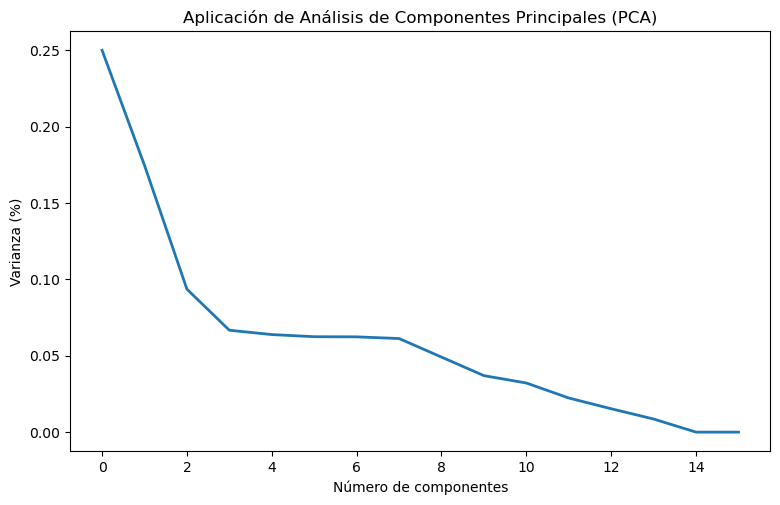

In [24]:
plt.figure(1, figsize=(10, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2) #Percentage of variance explained by each of the selected components.
plt.axis('tight')
plt.xlabel('Número de componentes')
plt.title('Aplicación de Análisis de Componentes Principales (PCA)')
plt.ylabel('Varianza (%)')

##  Univariate feature selection

In [14]:
#In univariate feature selection, we will use SelectKBest that removes all but the k highest scoring features. 
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest
# In this method we need to choose how many features we will use. For example, will k (number of features) be 5 or 10 or 15? 
# The answer is only trying or intuitively. I do not try all combinations but I only choose k = 5 and find best 5 features.

scaler = MinMaxScaler() # Escalar las características al rango [0, 1]

#5 features para probar, despues de ejecutasr rfecv se utiliza k=8 que ese el nº óptimo
#select_feature = SelectKBest(chi2, k=5).fit(scaler.fit_transform(X_train), y_train) 
select_feature = SelectKBest(chi2, k=8).fit(scaler.fit_transform(X_train), y_train) 
selected_features = X.columns[select_feature.get_support(indices=True)]

print('Selected features:', selected_features)

Selected features: Index(['cap', 'len_origen_tag', 'len_dest_tag', 'degree', 'abs_flux',
       'Beam Irradiance (W/m2)', 'Plane of Array Irradiance (W/m2)',
       'Cell Temperature (C)'],
      dtype='object')


In [15]:
X_train_fs = select_feature.transform(X_train)
X_test_fs = select_feature.transform(X_test)

## Random Forest

In [52]:
inicl = time.time()

classifier = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 0) #estimators = trees

#42.5seg, 26.94seg (10 estimadores sin)
#64.379seg (25 estimadores sin)
#132.05seg (50 estimadores sin y RFECV)
#193.83seg (75 estimadores sin)
#223.597seg (85 estimadores sin)
#433.65seg (100 estimadores sin)
#529.88seg, 466.61seg (200 estimadores sin y RFECV)
classifier.fit(X_train, y_train)
#classifier.fit(X_train_pca, y_train) #145.77seg
#classifier.fit(X_train_fs, y_train) #30.41seg

fincl = time.time()
print(fincl-inicl) 

466.6117570400238


### Evaluación de features (classifier sin aplicar PCA o FS)

In [ ]:
#Feature importances are provided by the fitted attribute feature_importances_
# and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
#https://qu4nt.github.io/sklearn-doc-es/auto_examples/inspection/plot_permutation_importance.html

""" La importancia de la característica basada en impurezas clasifica las características numéricas como las 
características más importantes. Como resultado, ¡la variable no predictiva random_num se clasifica como la más importante!
Este problema se debe a dos limitaciones de la importancia de las características basadas en las impurezas:
las importancias basadas en las impurezas están sesgadas hacia las características de alta cardinalidad;
las importancias basadas en las impurezas se calculan sobre las estadísticas del conjunto de entrenamiento 
y por tanto, no reflejan la capacidad de la característica de ser útil para hacer predicciones que se generalicen 
al conjunto de prueba (cuando el modelo tiene suficiente capacidad). """

# Feature importance based on mean decrease in impurity

features_ranking = pd.Series(classifier.feature_importances_, index=X.columns)

plt.figure(figsize=(10, 6))  
features_ranking.plot(kind='bar')
plt.ylabel('Importancia')
plt.title('Importancia de las características del RF a partir de la Disminución Media de la Impureza (MDI)')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# The computation for full permutation importance is more costly. 
# Features are shuffled n times and the model refitted to estimate the importance of it. 

# Feature importance based on feature permutation

""" Como alternativa, las importancias de la permutación de rf se calculan en un conjunto de pruebas retenido. 
Esto muestra que la característica categórica de baja cardinalidad, «sex», es la característica más importante. """

result = permutation_importance(
    classifier, X_test, y_test, n_repeats=5, random_state=42, n_jobs=2
)

importances_mean_series = pd.Series(result.importances_mean, index=X.columns)

plt.figure(figsize=(10, 6))
importances_mean_series.plot(kind='bar')
plt.ylabel('Importancia')
plt.title('Importancia de las características del RF a partir de la permutación')
plt.xticks(rotation=45, ha='right')
plt.show()

### Recursive feature elimination with cross validation (classifier sin aplicar PCA o FS)

In [15]:
# The "accuracy" scoring is proportional to the number of correct classifications
#http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html 
# Now we will not only find best features but we also find how many features do we need for best accuracy.

rfecv = RFECV(estimator=classifier, step=1, cv=5, scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Nº óptimo de features :', rfecv.n_features_)
print('Mejores features :', X.columns[rfecv.support_])

# Nº óptimo de features : 8
# Mejores features : ['cap', 'dist', 'origen_id', 'dest_id', 
# 'len_origen_tag', 'len_dest_tag', 'total_balance', 'abs_flux'],

Nº óptimo de features : 8
Mejores features : Index(['cap', 'dist', 'origen_id', 'dest_id', 'len_origen_tag', 'len_dest_tag',
       'total_balance', 'abs_flux'],
      dtype='object')


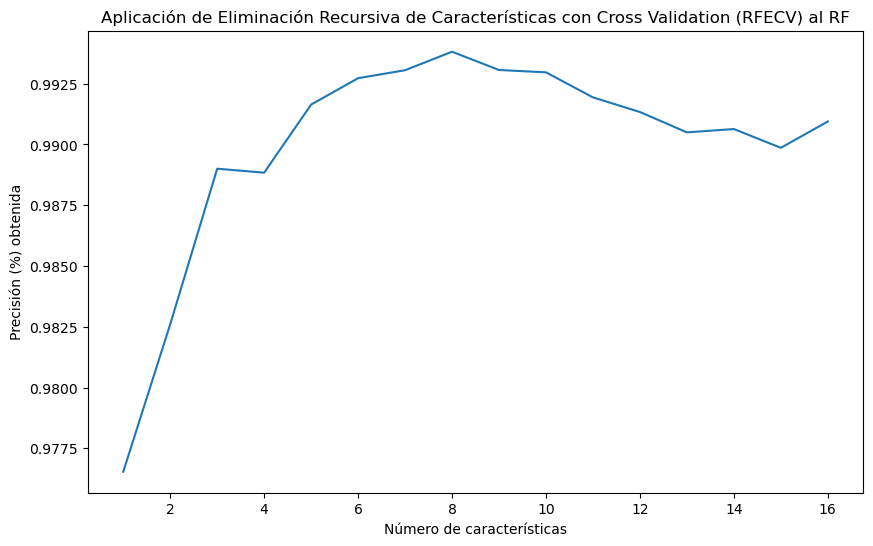

In [23]:
plt.figure(1, figsize=(10, 6))
plt.xlabel("Número de características")
plt.ylabel("Precisión (%) obtenida")
plt.title("Aplicación de Eliminación Recursiva de Características con Cross Validation (RFECV) al RF")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

## Evaluación

### Matriz de confusión

In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
#y_pred = classifier.predict(X_test_pca)
#y_pred = classifier.predict(X_test_fs)

cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

#0.9912896677438064 || [[376752    392] [  2972   6092]] sin 
#0.9752335529041346 || [[376593    551] [  9014     50]] con PCA (2)
#0.9764194423730218 || [[376965    179] [  8928    136]] con PCA (3)
#0.9779497058579832 || [[376555    589] [  7927   1137]] con Feature Selection (5)
#0.9773153326704781 || [[374986   2158] [  6603   2461]] con Feature Selection (8)
#0.9944485872897506 || [[376718    426] [  1718   7346]] con RFECV (8)


#25 estimadores
#0.9929286809180545 || [[376745    399] [  2332   6732]] sin 


#50 estimadores 
#0.9930866268953518 || [[376811    333] [  2337   6727]] sin
#0.9951140318170519 || [[376722    422] [  1465   7599]] con RFECV (8)


#75 estimadores
#0.9932575192642307 || [[376813    331] [  2273   6791]] sin


#100 estimadores 
#0.9932756442124451 || [[376826    318] [  2279   6785]] sin
#0.995173585218328  || [[376721    423] [  1441   7623]] con RFECV (8)


#200 estimadores
#0.9933818046234154 || [[376830    314] [  2242   6822]] sin
#0.9952616206810838 || [[376724    420] [  1410   7654]] con RFECV (8)                                                 con RFECV (8)

[[376724    420]
 [  1410   7654]]


0.9952616206810838

### K-Fold

In [11]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
#accuracies = cross_val_score(estimator = classifier, X = X_train_pca, y = y_train, cv = 10)
#accuracies = cross_val_score(estimator = classifier, X = X_train_fs, y = y_train, cv = 10)

print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100)) 

#Accuracy: 99.09 % Standard Deviation: 0.02 % sin 
#Accuracy: 97.54 % Standard Deviation: 0.01 % con PCA (2)
#Accuracy: 97.63 % Standard Deviation: 0.00 % con PCA (3)
#Accuracy: 97.79 % Standard Deviation: 0.02 % con Feature Selection (5)
#Accuracy: 97.69 % Standard Deviation: 0.01 % con Feature Selection (8)
#Accuracy: 99.41 % Standard Deviation: 0.02 % con RFECV (8)

Accuracy: 99.41 %
Standard Deviation: 0.02 %


## Figuras 

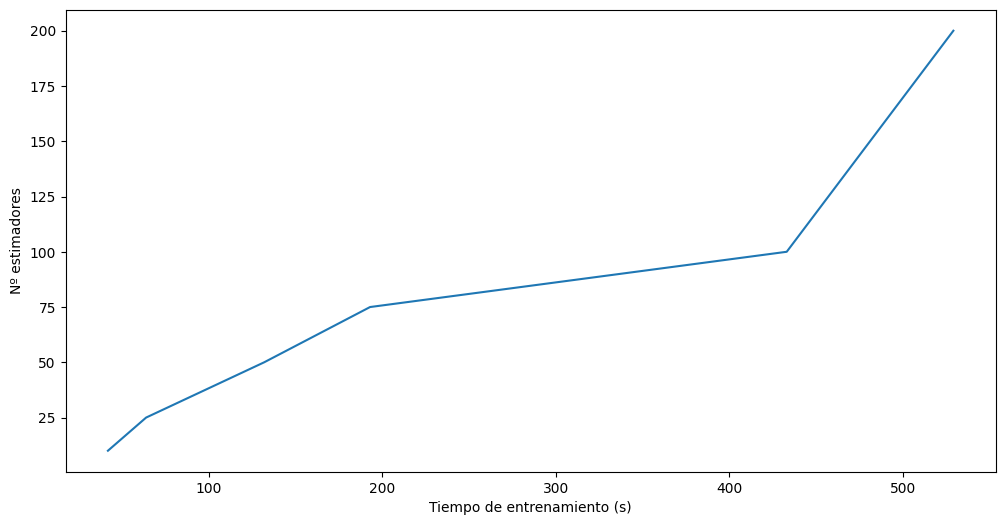

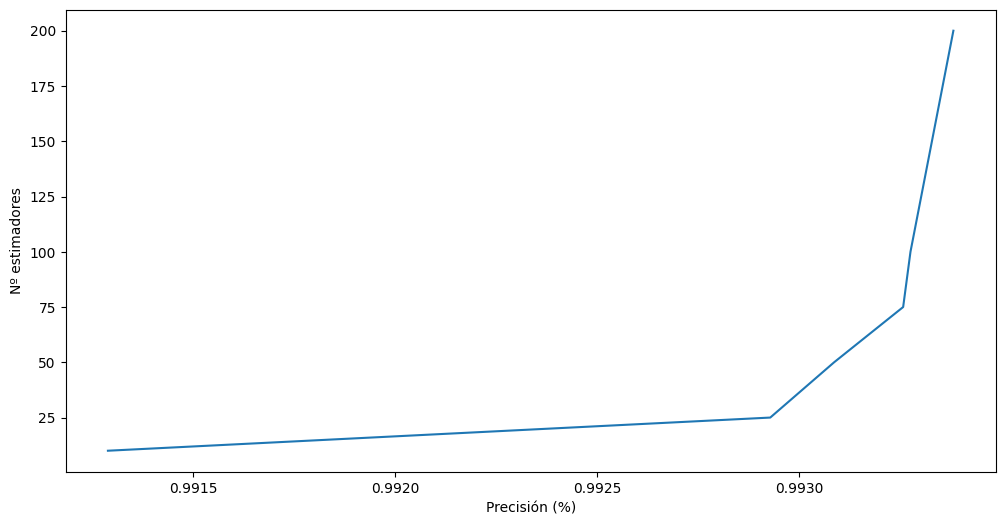

In [45]:
estimators = [10, 25, 50, 75, 100, 200]
tiempos = [42, 64, 132, 193, 433, 529]
accuracy = [0.9912896677438064, 0.9929286809180545, 0.9930866268953518, 0.9932575192642307, 0.9932756442124451, 0.9933818046234154]

plt.figure(figsize=(12, 6))
plt.plot(tiempos, estimators)
plt.ylabel('Nº estimadores')
plt.xlabel('Tiempo de entrenamiento (s)')
plt.title('')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(accuracy, estimators)
plt.ylabel('Nº estimadores')
plt.xlabel('Precisión (%)')
plt.title('')
plt.show()

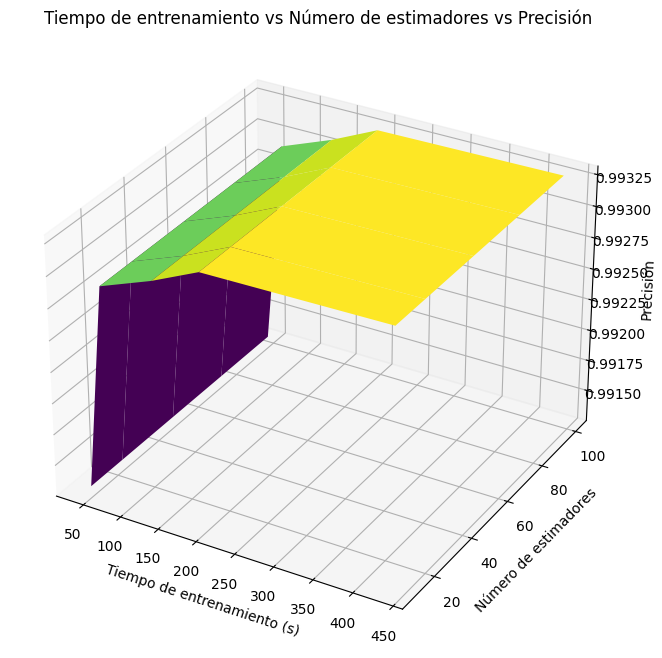

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#estimators = [10, 25, 40, 50, 75, 85, 100]
#tiempos = [42, 64, 105, 132, 193, 223, 433]

estimators = [10, 25, 50, 75, 100]
tiempos = [42, 64, 132, 193, 433]
accuracy = [0.9912896677438064, 0.9929286809180545, 0.9930866268953518, 0.9932575192642307, 0.9932756442124451]

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(tiempos, estimators)
Z = np.array([accuracy] * len(tiempos))
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Tiempo de entrenamiento (s)')
ax.set_ylabel('Número de estimadores')
ax.set_zlabel('Precisión')
ax.set_title('Tiempo de entrenamiento vs Número de estimadores vs Precisión')

plt.show()

In [44]:
"""for i, tree in enumerate(classifier.estimators_):
    node_data = StringIO()
    export_graphviz(tree, out_file=node_data)
    graph = pydotplus.graph_from_dot_data(node_data.getvalue())
    graph.write_png(f'tree_{i}.png') 

node_data = StringIO()
export_graphviz(classifier.estimators_[0], out_file=node_data)
graph = pydotplus.graph_from_dot_data(node_data.getvalue())
Image(graph.create_png()) """

"\nfor i, tree in enumerate(classifier.estimators_):\n    node_data = StringIO()\n    export_graphviz(tree, out_file=node_data)\n    graph = pydotplus.graph_from_dot_data(node_data.getvalue())\n    graph.write_png(f'tree_{i}.png') \n\nnode_data = StringIO()\nexport_graphviz(classifier.estimators_[0], out_file=node_data)\ngraph = pydotplus.graph_from_dot_data(node_data.getvalue())\nImage(graph.create_png()) "

In [37]:
for i, tree in enumerate(classifier.estimators_):
    dot = export_graphviz(tree,
                        feature_names=X.columns,  
                        filled=True,  
                        max_depth=4, 
                        impurity=False, 
                        proportion=True)
    
    dot_name = f"tree_{i}.dot"
    with open(dot_name, "w") as f:
        f.write(dot)

    os.system(f"dot -Tpng {dot_name} -o") #ver en http://www.webgraphviz.com/

In [38]:
X_set, y_set = X_train, y_train
X.columns

Index(['cap', 'dist', 'origen_id', 'dest_id', 'len_origen_tag', 'len_dest_tag',
       'criterion', 'degree', 'total_balance', 'abs_flux',
       'Beam Irradiance (W/m2)', 'Diffuse Irradiance (W/m2)',
       'Ambient Temperature (C)', 'Plane of Array Irradiance (W/m2)',
       'Cell Temperature (C)', 'modelo'],
      dtype='object')

In [43]:
""" plt.figure(figsize=(10, 6))

X1, X2 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=0.01),
                     np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=0.01))

plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha=0.75, cmap=ListedColormap(('red', 'green')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c=ListedColormap(('red', 'green'))(i), label=j)

plt.title('RF (Conjunto de Entrenamiento)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()  """

" plt.figure(figsize=(10, 6))\n\nX1, X2 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=0.01),\n                     np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=0.01))\n\nplt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),\n             alpha=0.75, cmap=ListedColormap(('red', 'green')))\n\nplt.xlim(X1.min(), X1.max())\nplt.ylim(X2.min(), X2.max())\n\nfor i, j in enumerate(np.unique(y_set)):\n    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],\n                c=ListedColormap(('red', 'green'))(i), label=j)\n\nplt.title('RF (Conjunto de Entrenamiento)')\nplt.xlabel('X1')\nplt.ylabel('X2')\nplt.legend()\nplt.show()  "

## Grid Search

### Estimación de tiempos

In [15]:
parameters = {
    #'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 
    'n_estimators': [20, 30, 40, 50],
    'criterion': ['entropy', 'gini']
    }

#https://datascience.stackexchange.com/questions/29495/how-to-estimate-gridsearchcv-computing-time

processors = 32
cv = 5 
combos = 1

for j in parameters.values():
    combos *= len(j)

num_models = combos * cv / processors 
seconds = num_models * (fincl-inicl)
minutes = seconds / 60
hours = minutes / 60

print("{:.6f}".format(hours), "| {:.6f}".format(minutes), "| {:.6f}".format(seconds)) 
#0.081282 | 4.876910 | 292.614584 (1-15)
#0.021675 | 1.300509 | 78.030556 (20-50)

0.021675 | 1.300509 | 78.030556


### Ejecución

In [14]:
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)

grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters) 

print(grid_search.best_estimator_)
#Best Accuracy: 99.18 %, Best Parameters: {'criterion': 'gini', 'n_estimators': 15} 
#Best Accuracy: 99.23 %,  Best Parameters: {'criterion': 'entropy', 'n_estimators': 50}

Best Accuracy: 99.23 %
Best Parameters: {'criterion': 'entropy', 'n_estimators': 50}
RandomForestClassifier(criterion='entropy', n_estimators=50, random_state=0)
